In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Przygotowanie danych

Zdecydowaliśmy nie brać pod uwagę autora utworu. Same gatunki są z nim skorelowane, ponieważ gatunki są udostępniane jako lista w jakich autor tworzy

Na pozostałych atrybutach przeprowadziliśmy backward selection. Jako funckję celu braliśmy pod uwagę średnią wariancję atrybutów we wszystkich utworzynych grupach. W poniższej tabeli przedstawiamy wyniki kolejnych iteracji w których wybierany był atrybut który najmniej pogarszał naszą funkcję celu. Kod programu znajduje się w pliku [selection.py](selection.py). Postanowiliśmy usunąć tylko atrybut explicit.

| Usunięty atrybut  | Średnia wariancja    |
|-------------------|--------------------- |
| None              | 0.011086775740732583 |
| explicit          | 0.017877785448255863 |
| key               | 0.024947679040287756 |
| acousticness      | 0.027180322665069444 |
| energy            | 0.030437649274463272 |
| valence           | 0.033694095208262914 |
| release_date      | 0.035882119370513874 |
| speechiness       | 0.03666206294648116  |
| liveness          | 0.038504847005265526 |
| loudness          | 0.039150961558759474 |
| danceability      | 0.04352528058903148  |
| tempo             | 0.046057781249811684 |


In [2]:
from prepare_data import prepare_grouping

In [3]:
# # Choose data from ranking
# from Ranking import Ranking

# r = Ranking(from_csv="sessions_popularity.csv", weeks=3, limit=0.25)
# r.group_by_weeks()

# result = r.get_tracks_for_last_week()

# tracks = tracks[tracks['id'].isin(result['track_id'])]

TODO
- Selekcja atrybutów
- Może ograniczyć gatunki i autorów sprawdzając czy występują minimalna liczbę razy, [Infrequent categories sklearn](https://scikit-learn.org/stable/modules/preprocessing.html#infrequent-categories)

# Model podstawowy

- mieszamy kolejność dataframe
- dokładamy do obecnej grupy kolejne utwory dopóki ich suma nie przekroczy godziny i następnie przechodzimy do następnej
- jeżeli ostatnia grupa ma mniej niż godzinę to ją rozdzielamy pomiędzy pozostałe

In [4]:
from grouping.base_model import base_model

# Model zaawansowany

- korzystamy z algorytmu agglomerative clustering z biblioteki scipy
- na początku każdy utwór ma przypisany unikalną grupę oraz otrzymujemy które kolejne klastry mają być łaczone
- łączymy kolejne klastry dopóki wszystkie klastry nie posiadają sumy długości utworów równej co najmniej godzinę
- na końcu jeżeli któraś grupa nie ma więcej niż godziny utworów to jej nie zwracamy

In [5]:
from grouping.advanced_model import advanced_model

In [6]:
prepared_data = prepare_grouping()

In [7]:
grouped_data = advanced_model(prepared_data)

merged_data = prepared_data.merge(grouped_data, on='id_x')

# selected_columns = [
#     'explicit', 'release_date', 'danceability', 'energy', 'key',
#     'loudness', 'speechiness', 'acousticness', 'instrumentalness',
#     'liveness', 'valence', 'tempo', 'group_x'
# ]


# adv = merged_data[selected_columns]
# mean_variance_group_adv = adv.groupby('group_x').var().mean(axis=1)
# mean_variance_group_adv = sum(mean_variance_group_adv) / len(mean_variance_group_adv)

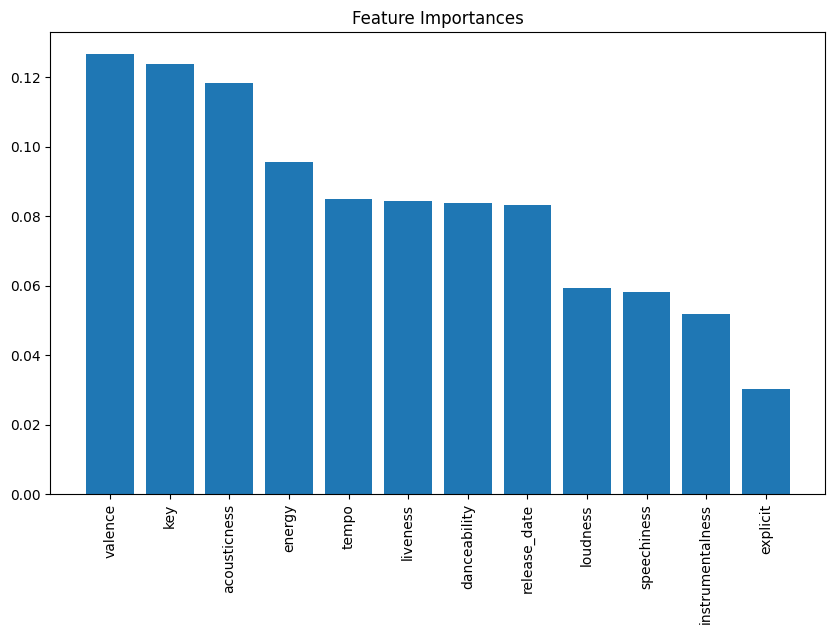

Wybrane cechy: Index(['valence', 'key', 'acousticness', 'energy', 'tempo', 'liveness',
       'danceability', 'release_date', 'loudness', 'speechiness'],
      dtype='object')


In [8]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Separacja cech i etykiet
selected_columns = [
    'explicit', 'release_date', 'danceability', 'energy', 'key',
    'loudness', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

# Separacja cech i etykiet
X = merged_data[selected_columns]
# X = merged_data.drop(columns=['id_x', 'group_x'])
y = merged_data['group_x']

# Tworzenie i trenowanie modelu Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Uzyskanie ważności cech
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Stworzenie wykresu ważności cech
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Wybranie najlepszych cech na podstawie ważności
num_features = 10  # liczba najlepszych cech do wybrania
selected_features = X.columns[indices][:num_features]

print(f'Wybrane cechy: {selected_features}')

In [9]:
list(X.columns[indices])

['valence',
 'key',
 'acousticness',
 'energy',
 'tempo',
 'liveness',
 'danceability',
 'release_date',
 'loudness',
 'speechiness',
 'instrumentalness',
 'explicit']

TODO
- ustawienie distance_threshold lub innego warunku przerwania
lub może 20+ grup

# TESTOWANIE

In [10]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [11]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


def pca_scatter(model, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(model)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.show()

In [12]:
test = prepared_data[:100]
params = test.drop(columns=['id_x', 'duration_ms'])

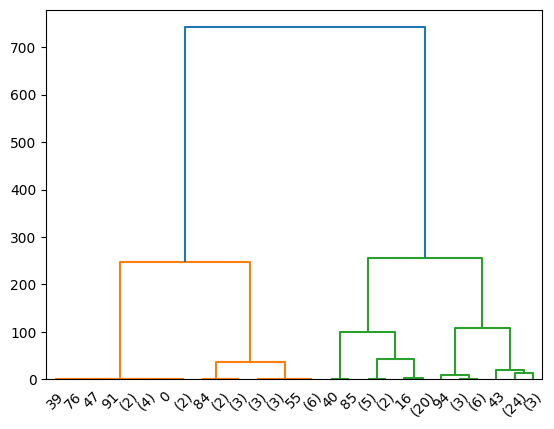

In [13]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(params)

plot_dendrogram(clustering, truncate_mode="level", p=4)

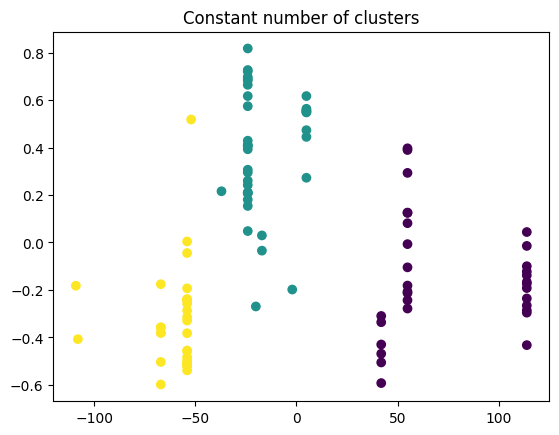

In [14]:
clustering = AgglomerativeClustering(n_clusters=3).fit(params)
labels = clustering.labels_
pca_scatter(params, labels, 'Constant number of clusters')

In [15]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([32, 38, 30]))

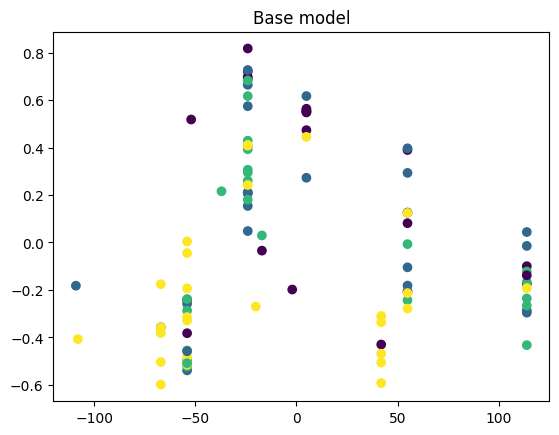

In [16]:
base = base_model(test)

labels = base['group']
pca_scatter(params, labels, 'Base model')

In [17]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3]), array([22, 25, 24, 29]))

In [18]:
group_id = labels[0]
result = base[base['group'] == group_id]['id']
first_group_base = begin_prepared_data[begin_prepared_data['id_x'].isin(result)]

NameError: name 'begin_prepared_data' is not defined

In [ ]:
first_group_base['duration_ms'].sum() / 1000 / 60 / 60

1.289261111111111

In [ ]:
first_group_base.describe()

,duration_ms,explicit,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,25.000000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,185653.600000,0.0,0.197066,0.592450,0.541915,0.400000,0.765161,0.077376,0.529150,0.056456,0.164241,0.722288,0.623539
std,58360.777573,0.0,0.072873,0.141825,0.253868,0.318182,0.085638,0.029958,0.306002,0.165646,0.159911,0.226085,0.140250
min,125960.000000,0.0,0.000000,0.282586,0.081985,0.000000,0.562038,0.040121,0.004373,0.000000,0.038306,0.201226,0.400202
25%,146480.000000,0.0,0.188533,0.493222,0.320998,0.181818,0.728982,0.055958,0.301410,0.000000,0.071125,0.642492,0.501093
50%,164320.000000,0.0,0.200093,0.600626,0.540942,0.363636,0.779513,0.070739,0.626007,0.000005,0.100321,0.794688,0.609516
75%,196667.000000,0.0,0.215765,0.680918,0.758868,0.636364,0.809186,0.089291,0.754032,0.005143,0.287711,0.887640,0.755159
max,332400.000000,0.0,0.341493,0.792492,0.961661,0.909091,0.915928,0.155354,0.997984,0.762729,0.768092,0.983657,0.883875


In [ ]:
first_group_base['id_artist'].value_counts()

id_artist
22bE4uQ6baNwSHPVcDxLCe    3
43ZHCT0cAZBISjO8DG9PnE    2
60df5JBRRPcnSpsIMxxwQm    2
3WrFJ7ztbogyGnTHbHJFl2    2
70cRZdQywnSFp9pnc2WTCE    2
6hnWRPzGGKiapVX1UCdEAC    2
6kACVPfCOnqzgfEF5ryl0x    1
5V0MlUE1Bft0mbLlND7FJz    1
1Mxqyy3pSjf8kZZL4QVxS0    1
1SQRv42e4PjEYfPhS0Tk9E    1
7fAKtXSdNInWAIf0jVUz65    1
19eLuQmk9aCobbVDHc6eek    1
74ASZWbe4lXaubB36ztrGX    1
3koiLjNrgRTNbOwViDipeA    1
7G1GBhoKtEPnP86X2PvEYO    1
7mEIug7XUlQHikrFxjTWes    1
2QsynagSdAqZj3U9HgDzjD    1
4MVyzYMgTwdP7Z49wAZHx0    1
Name: count, dtype: int64

In [ ]:
first_group_base['genres'].explode().value_counts()

genres
adult standards       11
classic rock          10
rock                  10
soul                   7
mellow gold            6
british invasion       6
folk rock              5
classic soul           5
rock-and-roll          4
folk                   4
brill building pop     3
vocal jazz             3
album rock             3
psychedelic rock       3
funk                   3
melancholia            2
merseybeat             2
beatlesque             2
swing                  2
rockabilly             2
jazz blues             2
soft rock              2
singer-songwriter      2
country rock           2
southern soul          2
memphis soul           2
soul blues             2
roots rock             2
arkansas country       1
art rock               1
outlaw country         1
easy listening         1
lounge                 1
dixieland              1
protopunk              1
glam rock              1
harlem renaissance     1
mpb                    1
jazz trumpet           1
new orleans jazz  

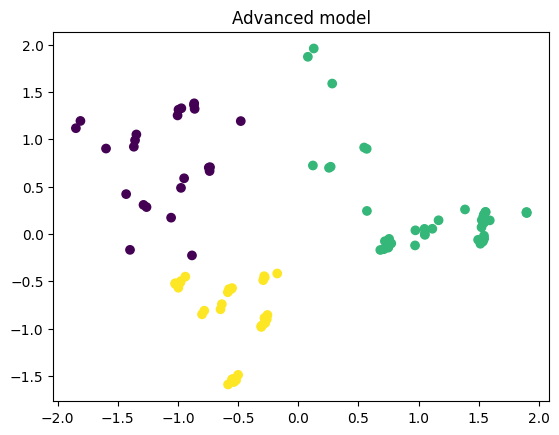

In [ ]:
advanced = advanced_model(test)
labels = advanced['group']
params_dropped = test[test['id_x'].isin(advanced['id_x'])].drop(columns=['id_x', 'duration_ms', 'group'])
pca_scatter(params_dropped, np.array(labels), 'Advanced model')

In [ ]:
np.unique(labels, return_counts=True)

(array([193, 195, 196]), array([24, 42, 34]))

In [ ]:
group_id = labels[0]
result = advanced[advanced['group'] == group_id]['id_x']
first_group_adv = begin_prepared_data[begin_prepared_data['id_x'].isin(result)]

In [ ]:
first_group_adv['duration_ms'].sum() / 1000 / 60 / 60

2.2281719444444446

In [ ]:
first_group_adv.describe()

,duration_ms,explicit,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,42.000000,42.0,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,190986.166667,0.0,0.248474,0.583743,0.481810,0.430736,0.743932,0.073594,0.532428,0.030127,0.193986,0.696775,0.590923
std,51747.426691,0.0,0.077095,0.138829,0.198894,0.349538,0.074268,0.035495,0.289302,0.126751,0.175075,0.250593,0.145210
min,125960.000000,0.0,0.000000,0.316997,0.080169,0.000000,0.562038,0.038160,0.010886,0.000000,0.037789,0.159346,0.400202
25%,161033.500000,0.0,0.205912,0.469760,0.326294,0.090909,0.682790,0.050528,0.308719,0.000000,0.084093,0.485700,0.478552
50%,176933.000000,0.0,0.264121,0.587591,0.497558,0.454545,0.747442,0.061689,0.595766,0.000019,0.124133,0.765577,0.559919
75%,195893.500000,0.0,0.308393,0.690563,0.582812,0.795455,0.796718,0.084955,0.754788,0.002536,0.243969,0.919816,0.689761
max,336733.000000,0.0,0.337148,0.839416,0.853707,0.909091,0.911252,0.190045,0.997984,0.761711,0.768092,0.992850,0.976903


In [ ]:
first_group_adv['id_artist'].value_counts()

id_artist
7nwUJBm0HE4ZxD3f5cy5ok    4
43ZHCT0cAZBISjO8DG9PnE    3
7G1GBhoKtEPnP86X2PvEYO    3
60df5JBRRPcnSpsIMxxwQm    3
7guDJrEfX3qb6FEbdPA5qi    3
3koiLjNrgRTNbOwViDipeA    2
6hnWRPzGGKiapVX1UCdEAC    2
6kACVPfCOnqzgfEF5ryl0x    2
1eEfMU2AhEo7XnKgL7c304    2
32vWCbZh0xZ4o9gkz4PsEU    2
3PhoLpVuITZKcymswpck5b    2
7mEIug7XUlQHikrFxjTWes    2
7fAKtXSdNInWAIf0jVUz65    1
19eLuQmk9aCobbVDHc6eek    1
5V0MlUE1Bft0mbLlND7FJz    1
1Mxqyy3pSjf8kZZL4QVxS0    1
2iE18Oxc8YSumAU232n4rW    1
5W5bDNCqJ1jbCgTxDD0Cb3    1
4PPoI9LuYeFX8V674Z1R6l    1
3RwQ26hR2tJtA8F9p2n7jG    1
3fMbdgg4jU18AjLCKBhRSm    1
2y8Jo9CKhJvtfeKOsYzRdT    1
2QsynagSdAqZj3U9HgDzjD    1
7EK1bQADBoqbYXnT4Cqv9w    1
Name: count, dtype: int64

In [ ]:
first_group_adv['genres'].explode().value_counts()

genres
adult standards        24
soul                   20
classic soul           12
funk                    9
memphis soul            8
jazz blues              8
soft rock               8
mellow gold             8
southern soul           7
motown                  7
brill building pop      5
quiet storm             5
vocal jazz              5
rock-and-roll           5
classic country pop     4
rockabilly              3
outlaw country          3
folk                    3
singer-songwriter       3
torch song              3
folk rock               3
soul jazz               3
country                 3
soul blues              3
piano rock              2
swing                   2
arkansas country        2
northern soul           2
yacht rock              2
glam rock               2
country dawn            2
indie r&b               2
easy listening          1
lounge                  1
jovem guarda            1
new orleans jazz        1
jazz trumpet            1
harlem renaissance      1
dixie

In [ ]:
def test_data(data, count=100):
    test = data[:count]
    params = test.drop(columns=['id_x', 'duration_ms'])


    base = base_model(test)
    labels = base['group']
    pca_scatter(params, labels, 'Base model')
    print(np.unique(labels, return_counts=True))

    bas = pd.concat([params, labels], axis=1)

    mean_variance_group_base = bas.groupby('group').var().mean(axis=1)
    mean_variance_group_base = sum(mean_variance_group_base) / len(mean_variance_group_base)


    advanced = advanced_model(test)
    labels = advanced['group']
    params_dropped = test[test['id_x'].isin(advanced['id_x'])].drop(columns=['id_x', 'duration_ms', 'group'])
    pca_scatter(params_dropped, np.array(labels), 'Advanced model')
    print(np.unique(labels, return_counts=True))

    adv = pd.concat([params_dropped, labels], axis=1)
    mean_variance_group_adv = adv.groupby('group').var().mean(axis=1)
    mean_variance_group_adv = sum(mean_variance_group_adv) / len(mean_variance_group_adv)


    print(mean_variance_group_base)
    print(mean_variance_group_adv)

    if mean_variance_group_base > mean_variance_group_adv:
        print('advanced')
    elif mean_variance_group_base < mean_variance_group_adv:
        print('base')
    else:
        print('same')

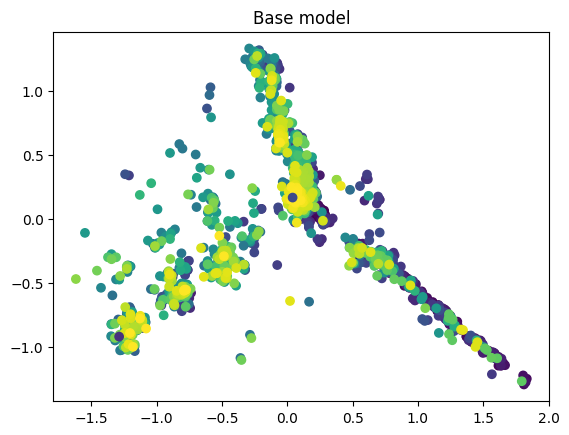

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132]), array([22, 19, 14, 15, 17, 14, 14, 12, 16, 15, 15, 12, 15, 16, 13, 15, 14,
       15, 15, 14, 16, 15, 13, 15, 15, 15, 15, 16, 14, 17, 16, 15, 15, 15,
       15, 16, 16, 15, 15, 16, 16, 17, 16, 16, 16, 16, 16, 17, 16, 17, 17,
       15, 17, 18, 16, 16, 17,

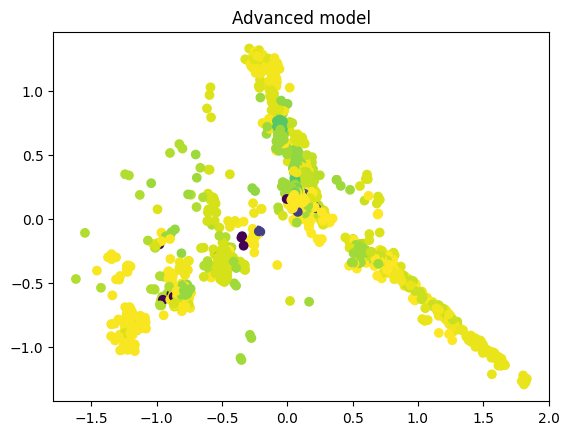

(array([4069, 4111, 4129, 4241, 4256, 4263, 4265, 4268, 4269, 4274, 4277,
       4278, 4280, 4282, 4287, 4289, 4290, 4291, 4294, 4296, 4297, 4298,
       4300, 4301, 4302]), array([ 18,  38,  18,  48,  50,  65,  55, 154,  72,  57,  43,  27,  70,
        64, 154,  76,  68,  58,  83, 111,  56,  98, 222, 362,  97]))
0.0033286775048607
0.0023035714594996466
advanced


In [ ]:
test_data(prepared_data, len(prepared_data))

# Wnioski 
Model zaawansowany tworzy bardziej jednorodne grupy. Ma on jednak na razie trochę wad.
- tracimy część danych podczas ostatniego kroku bo nie będą one zwracane
- powinniśmy ustawić dodatkowo distance_threshold aby algorytm nie łączył niepotrzebnie klastrów. Dobrze widoczne jest to na dendogramie, gdy mało liczna grupa, która jeszcze nie spełniła warunku czasowego ma wysoki dystans do kolejnego połączenia. Aktualnie tracimy przez to podobieństwo danych w danej grupie nie zyskując zarazem nowych prawidłowych grup.